In [1]:
import os.path as osp

import PIL.Image as PImage
from torchvision.datasets.folder import DatasetFolder, IMG_EXTENSIONS
from torchvision.transforms import InterpolationMode, transforms

import os
import os.path as osp
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms

import gc
import os
import shutil
import sys
import time
import warnings
from functools import partial

import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import stats
import pickle
import pandas as pd
import tensorly as tl
from tensorly.decomposition import non_negative_parafac, non_negative_tucker
from sklearn.metrics.pairwise import cosine_similarity


In [2]:
with open("activity_dict_region.pkl", 'rb') as f:
    activity_dict = pickle.load(f)

In [3]:
results = {}
for region in [#'VISam', 
               'VISp'#, 'VISl', 'VISrl', 'VISpm', 'VISal'
               ]:
    print(f'Start region: {region}')

    session_list = list(activity_dict[region].keys())
    for session in session_list:
        if len(activity_dict[region][session].keys()) != 5850:
            session_list.remove(session)
        
    activity_dict_all = {}
    for image in activity_dict[region][session].keys():
        temp = pd.DataFrame()
        for session in session_list:
            temp = pd.concat((temp, pd.DataFrame(activity_dict[region][session][image])), axis=0)
        
        global_min = temp.min()
        global_max = temp.max()
        activity_dict_all[image] = (temp - global_min) / (global_max - global_min + 1e-8)

Start region: VISp


In [4]:
activity_all = []
for i in range(117):
    temp = []
    for key in activity_dict_all.keys():
        if key.split("_")[0] == str(i):
            temp.append(activity_dict_all[key])
    temp = np.stack(temp)
    temp = temp.mean(axis=0)
    activity_all.append(temp)

activity_all = np.stack(activity_all)

In [5]:
def non_negative_tensor_factorization(tensor, rank, method='parafac', n_iter_max=1000, init='random', tol=1e-7):
    tensor = tl.tensor(np.maximum(tensor, 0))
    
    if method == 'parafac':
        factors = non_negative_parafac(
            tensor, 
            rank=rank, 
            n_iter_max=n_iter_max, 
            init=init, 
            tol=tol, 
            verbose=True
        )
        return factors
        
    elif method == 'tucker':
        core, factors = non_negative_tucker(
            tensor, 
            rank=[rank, rank, rank],  # 为每个模式指定秩
            n_iter_max=n_iter_max, 
            init=init, 
            tol=tol, 
            verbose=True
        )
        return core, factors
        
    else:
        raise ValueError("方法必须是'parafac'或'tucker'")

In [6]:
rank = 20
weights, factors = non_negative_parafac(activity_all, rank=rank, n_iter_max=500)


In [7]:
reconstructed = tl.cp_to_tensor((weights, factors))
error = tl.norm(activity_all - reconstructed) / tl.norm(activity_all)

In [8]:
image_factors = factors[0]

In [9]:
import plotly.graph_objects as go
import numpy as np
import pandas as pd


fig = go.Figure()
fig.add_trace(go.Scatter3d(
    x=image_factors[:, 0],
    y=image_factors[:, 1],
    z=image_factors[:, 2],
    showlegend=True
))


fig.show()

In [10]:
import os
import os.path as osp
import torch, torchvision
import random
import numpy as np
import PIL.Image as PImage, PIL.ImageDraw as PImageDraw
setattr(torch.nn.Linear, 'reset_parameters', lambda self: None)     
setattr(torch.nn.LayerNorm, 'reset_parameters', lambda self: None)  
sys.path.append('/media/ubuntu/sda/neuropixels/visual_decode/my_VAR')
from models import VQVAE, build_vae_var

MODEL_DEPTH = 16   

vae_ckpt = '/media/ubuntu/sda/neuropixels/visual_decode/my_VAR/vae_ch160v4096z32.pth'

FOR_512_px = MODEL_DEPTH == 16

patch_nums = (1, 2, 3, 4, 5, 6, 8, 10, 13, 16)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae, var = build_vae_var(
    V=4096, Cvae=32, ch=160, share_quant_resi=4,   
    device=device, patch_nums=patch_nums,
    num_classes=1000, depth=MODEL_DEPTH, shared_aln=FOR_512_px)

vae.load_state_dict(torch.load(vae_ckpt, map_location='cpu'), strict=True)
del var

/home/ubuntu/.conda/envs/visual_decoding/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html




[constructor]  ==== flash_if_available=True (0/16), fused_if_available=True (fusing_add_ln=0/16, fusing_mlp=0/16) ==== 
    [VAR config ] embed_dim=1024, num_heads=16, depth=16, mlp_ratio=4.0
    [drop ratios ] drop_rate=0.0, attn_drop_rate=0.0, drop_path_rate=0.0666667 (tensor([0.0000, 0.0044, 0.0089, 0.0133, 0.0178, 0.0222, 0.0267, 0.0311, 0.0356,
        0.0400, 0.0444, 0.0489, 0.0533, 0.0578, 0.0622, 0.0667]))

[init_weights] VAR with init_std=0.0180422


In [11]:
transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x * 2 - 1)  # 归一化到[-1, 1]
    ])
    
images = []
valid_paths = []
valid_labels = []


for i in range(117):
    image = Image.open(f'/media/ubuntu/sda/neuropixels/nature_scene/natural_scene_{i}.tiff').convert("RGB")
    img_tensor = transform(image)
    images.append(img_tensor)

images = torch.stack(images)

In [12]:
def extract_multiscale_features_for_similarity(vae, images, device):
    """提取图像在不同scale的特征用于相似度分析"""
    vae.eval()
    features_by_scale = []
    
    print("Extracting multiscale features...")
    with torch.no_grad():
        for i, img in enumerate(images):
            if i % 20 == 0:
                print(f"Processing image {i+1}/{len(images)}")
            
            img = img.unsqueeze(0).to(device)  
            
            encoded_features = vae.quant_conv(vae.encoder(img))
            
            ms_f_hat = vae.quantize.f_to_idxBl_or_fhat(encoded_features, to_fhat=True)
            
            scale_features = []
            for f_hat in ms_f_hat:
                flat_features = f_hat.view(f_hat.size(0), -1).cpu().numpy()
                scale_features.append(flat_features[0])  
            
            features_by_scale.append(scale_features)
    
    return features_by_scale

In [13]:
features_by_scale = extract_multiscale_features_for_similarity(vae, images, device)


Extracting multiscale features...
Processing image 1/117
Processing image 21/117
Processing image 41/117
Processing image 61/117
Processing image 81/117
Processing image 101/117


In [14]:
def compute_similarity_matrix_for_scale(features_list, scale_idx):
    """计算指定scale的相似度矩阵"""
    # 提取指定scale的特征
    scale_features = [features[scale_idx] for features in features_list]
    scale_features = np.array(scale_features)
    
    # 计算余弦相似度
    similarity_matrix = cosine_similarity(scale_features)
    
    return similarity_matrix

In [15]:
similarity_matrix = []
for scale_idx in range(10):
    similarity_matrix.append(compute_similarity_matrix_for_scale(features_by_scale, scale_idx))

In [16]:
similarity_matrix_neuron = cosine_similarity(image_factors)

In [17]:
upper_tri_indices = np.triu_indices(117, k=1)
unique_pairs_neuron = similarity_matrix_neuron[upper_tri_indices]
unique_pairs = []
for scale_idx in range(10):
    unique_pairs.append(similarity_matrix[scale_idx][upper_tri_indices])

In [19]:
import seaborn as sns

In [25]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
with PdfPages("similarity_matrix.pdf") as pdf:
    plt.figure(figsize=(5, 5))
    sns.heatmap(similarity_matrix_neuron, cbar= False)
    plt.xticks([])
    plt.yticks([])
    pdf.savefig()
    plt.close()


    for i in range(10):
        plt.figure(figsize=(5, 5))
        sns.heatmap(similarity_matrix[i], cbar= False)
        plt.xticks([])
        plt.yticks([])
        pdf.savefig()
        plt.close()

<Axes: >

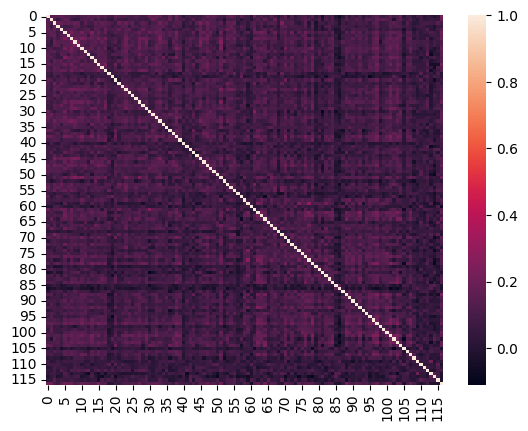

In [21]:
sns.heatmap(similarity_matrix[8])

In [104]:
image = pd.read_csv("/media/ubuntu/sda/Monkey/scripts/test_image.csv")

In [113]:
from matplotlib.backends.backend_pdf import PdfPages
with PdfPages("image.pdf") as pdf:
    for path in image['things_path'].values:
        image_single = Image.open(f'/media/ubuntu/sda/visual_stimuli_pattern/things/object_images/{path}')
        plt.imshow(np.array(image_single)[:, :, 0])
        pdf.savefig()
        plt.close()
